In [33]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [324]:
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, sparsity=0.5):
        super(MaskedLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Dense weight with mask
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.mask = (torch.rand(out_features, in_features) < sparsity).float()

        # Bias
        #self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        masked_weight = self.weight * self.mask  # Apply mask
        return torch.matmul(x, masked_weight.t()) #+ self.bias

In [645]:
class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int, sparsity: float) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = MaskedLinear(hidden_size, hidden_size, sparsity)
        self.h2o = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden_state) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns computed output and tanh(i2h + h2h)
        Inputs
        ------
        x: Input vector
        hidden_state: Previous hidden state
        Outputs
        -------
        out: Linear output (without activation because of how pytorch works)
        hidden_state: New hidden state matrix
        """
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        out = self.h2o(hidden_state)
        return torch.sigmoid(out), hidden_state
        
    def init_zero_hidden(self, batch_size=1) -> torch.Tensor:
        """
        Helper function.
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

In [326]:
def generate_sine_wave(t, frequency, phase_shift, amplitude=1.0):
    """
    Generate a sine wave with specified parameters.

    Parameters:
    - frequency: Frequency of the sine wave in Hz
    - phase_shift: Phase shift of the sine wave in radians
    - duration: Duration of the sine wave in seconds
    - sampling_rate: Sampling rate in Hz (samples per second)
    - amplitude: Amplitude of the sine wave (default: 1.0)

    Returns:
    - t: Time array
    - y: Sine wave values
    """
    
    # Generate sine wave using the given parameters
    y = amplitude * np.sin(2 * np.pi * frequency * t + phase_shift)
    
    return y

In [327]:
import numpy as np
import matplotlib.pyplot as plt

# Define the square wave using the Fourier series
def square_wave(x, freq, phase_shift, amplitude, terms=10):
    """
    Generate a square wave using the Fourier series.

    Parameters:
    x (numpy array): Input array (e.g., time or angle in radians).
    terms (int): Number of terms in the Fourier series.

    Returns:
    numpy array: Approximation of the square wave.
    """
    result = np.zeros_like(x)
    for n in range(1, 2 * terms, 2):  # Odd harmonics: 1, 3, 5, ...
        result += generate_sine_wave(n*x, freq, n*phase_shift, amplitude)/n
        #result += np.sin(n * x) / n
    return (4 / np.pi) * result


In [347]:
in_dim = 1
out_dim = 1
hidden_size = 30
learning_rate = 0.001
sparsity = 0.1
leaky_rate = 0.3

shift= 8 

model = RNN(in_dim, hidden_size, out_dim, sparsity)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

hidden_prev = torch.zeros(1, 1, hidden_size)

amplitude = 1
n_terms = 3

sampling_rate = 1000
duration = 1

num_time_steps = int(sampling_rate * duration)

In [348]:
t = np.linspace(0, duration, num_time_steps, endpoint=False)

for iter in range(4000):
    # randomly generate start point from 0 to 2
    #start = np.random.randint(3, size=1)[0]
    # eg. from 0 to 10, create 50 points in between
    phase_shift = np.random.rand(1) * 2 * np.pi
    data = square_wave(t,5,phase_shift,amplitude, n_terms)
    data = data.reshape(num_time_steps, 1)
    # x: 49 points 0-49; y: 49 points 1-50
    x = torch.tensor(data[:-shift]).float().reshape(1, num_time_steps - shift, 1)  # [b, seq_len, fea_len]
    y = torch.tensor(data[shift:]).float().reshape(1, num_time_steps - shift, 1)  # [b, seq_len, fea_len]

    output, hidden_prev = model(x, hidden_prev)
    hidden_prev = hidden_prev.detach()

    # print(f"output {output.shape}, y {y.shape}")
    loss = criterion(output, y)
    model.zero_grad()
    # optimizer.zero_grad()
    # both zero_grad() are the same if model.parameters() is feed to the same optimizer
    # only matters if multiple models using same optimizer or multiple optims used for a model
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
        print(f"iteration: {iter}, loss {loss.item()}")

iteration: 0, loss 1.0573651790618896
iteration: 100, loss 0.2797089219093323
iteration: 200, loss 0.16330137848854065
iteration: 300, loss 0.17623260617256165
iteration: 400, loss 0.13813547790050507
iteration: 500, loss 0.21473091840744019
iteration: 600, loss 0.18729247152805328
iteration: 700, loss 0.089653380215168
iteration: 800, loss 0.08332980424165726
iteration: 900, loss 0.1066913977265358
iteration: 1000, loss 0.10924813896417618
iteration: 1100, loss 0.15107053518295288
iteration: 1200, loss 0.19548577070236206
iteration: 1300, loss 0.1253136694431305
iteration: 1400, loss 0.14745739102363586
iteration: 1500, loss 0.09561734646558762
iteration: 1600, loss 0.16086624562740326
iteration: 1700, loss 0.149056077003479
iteration: 1800, loss 0.11105795949697495
iteration: 1900, loss 0.1191113069653511
iteration: 2000, loss 0.1399778574705124
iteration: 2100, loss 0.13107842206954956
iteration: 2200, loss 0.11525102704763412
iteration: 2300, loss 0.1336362212896347
iteration: 2400

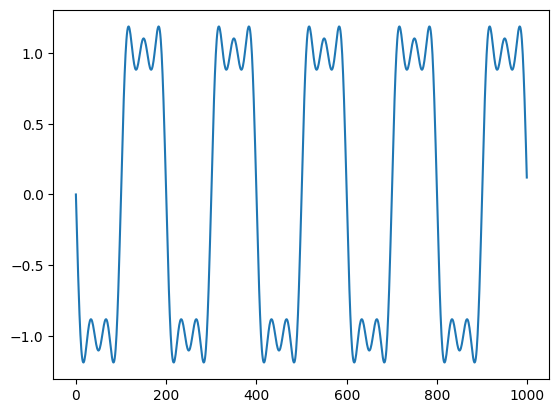

In [439]:
start = np.random.randint(3, size=1)[0]
data = square_wave(t,5,np.pi,1,3)

plt.plot(data)
plt.show()

In [362]:
data = data.reshape(num_time_steps, 1)
x = torch.tensor(data[:-shift]).float().reshape(1, num_time_steps-shift, 1)
input_x = x[:, 0, :]  # select first point
input_x.shape

torch.Size([1, 1])

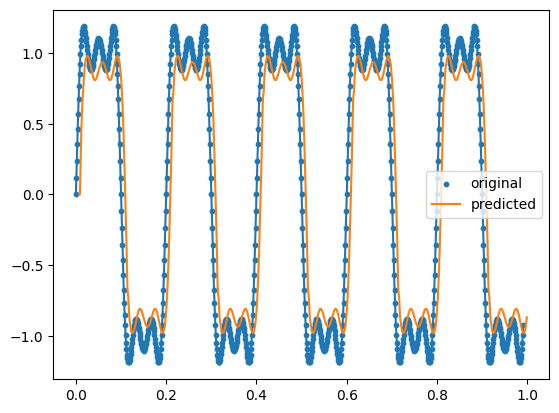

In [363]:
hidden_prev = torch.zeros(1, 1, hidden_size)

preds = []
for idx in range(x.shape[1]):
    input_x = input_x.reshape(1, 1, 1)  # reshape it for model feeding
    pred, hidden_prev = model(input_x, hidden_prev)
    # print(pred.shape)
    # print(hidden_prev.shape)
    input_x = x[:,idx,:]
    preds.append(pred.detach().numpy().ravel()[0])

x = x.data.numpy().ravel()
plt.scatter(t[:-shift], x.ravel(), s=10, label='original')
plt.plot(t[:-shift], x.ravel())

#plt.scatter(t[shift:], preds, label='predicted')
plt.plot(t[shift:], preds, label='predicted')
plt.legend()
plt.show()

In [417]:
def train(model,
          n_iter,
          hidden_size,
          learning_rate,
          function,
          shift, 
          duration,
          num_time_steps):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    t = np.linspace(0, duration, num_time_steps, endpoint=False)

    hidden_prev = torch.zeros(1, 1, hidden_size)
    
    for it in range(n_iter):
        # randomly generate start point from 0 to 2
        #start = np.random.randint(3, size=1)[0]
        # eg. from 0 to 10, create 50 points in between
        phase_shift = np.random.rand(1) * 2 * np.pi
        data = function(t,phase_shift)
        data = data.reshape(num_time_steps, 1)
        # x: 49 points 0-49; y: 49 points 1-50
        x = torch.tensor(data[:-shift]).float().reshape(1, num_time_steps - shift, 1)  # [b, seq_len, fea_len]
        y = torch.tensor(data[shift:]).float().reshape(1, num_time_steps - shift, 1)  # [b, seq_len, fea_len]

        output, hidden_prev = model(x, hidden_prev)
        hidden_prev = hidden_prev.detach()

        # print(f"output {output.shape}, y {y.shape}")
        loss = criterion(output, y)
        model.zero_grad()
        # optimizer.zero_grad()
        # both zero_grad() are the same if model.parameters() is feed to the same optimizer
        # only matters if multiple models using same optimizer or multiple optims used for a model
        loss.backward()
        optimizer.step()

        #if it % 100 == 0:
        #    print(f"iteration: {iter}, loss {loss.item()}")

In [566]:
@torch.no_grad()
def test(model,
          hidden_size,
          function,
          shift, 
          duration,
          num_time_steps):
    
    t = np.linspace(0, duration, num_time_steps, endpoint=False)
    
    p_shift = np.random.rand() * 2 * np.pi
    
    data = function(t, p_shift)

    data = data.reshape(num_time_steps, 1)
    x = torch.tensor(data[:-shift]).float().reshape(1, num_time_steps-shift, 1)
    input_x = x[:, 0, :]  # select first point
    input_x.shape
    
    hidden_prev = torch.zeros(1, 1, hidden_size)

    preds = []
    for idx in range(x.shape[1]):
        input_x = input_x.reshape(1, 1, 1)  # reshape it for model feeding
        pred, hidden_prev = model(input_x, hidden_prev)
        # print(pred.shape)
        # print(hidden_prev.shape)
        input_x = x[:,idx,:]
        preds.append(pred.detach().numpy().ravel()[0])

    x = x.data.numpy().ravel()
    plt.scatter(t[:-shift], x.ravel(), s=10, label='original')
    plt.plot(t[:-shift], x.ravel())

    #plt.scatter(t[shift:], preds, label='predicted')
    plt.plot(t[shift:], preds, label='predicted')
    plt.legend()
    plt.show()

In [587]:
def train2(model,
          n_iter,
          hidden_size,
          learning_rate,
          function,
          target_function,
          shift, 
          duration,
          num_time_steps):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    t = np.linspace(0, duration, num_time_steps, endpoint=False)

    hidden_prev = torch.zeros(1, 1, hidden_size)
    
    for it in range(n_iter):
        # randomly generate start point from 0 to 2
        #start = np.random.randint(3, size=1)[0]
        # eg. from 0 to 10, create 50 points in between
        phase_shift = np.random.rand(1) * 2 * np.pi
        input_data = function(t,phase_shift)
        input_data = input_data.reshape(num_time_steps, 1)
        
        target_data = target_function(t,phase_shift)
        target_data = target_data.reshape(num_time_steps, 1)
        
        x = torch.tensor(input_data).float().reshape(1, num_time_steps, 1)  # [b, seq_len, fea_len]
        y = torch.tensor(target_data).float().reshape(1, num_time_steps, 1)  # [b, seq_len, fea_len]

        output, hidden_prev = model(x, hidden_prev)
        hidden_prev = hidden_prev.detach()

        # print(f"output {output.shape}, y {y.shape}")
        loss = criterion(output, y)
        model.zero_grad()
        # optimizer.zero_grad()
        # both zero_grad() are the same if model.parameters() is feed to the same optimizer
        # only matters if multiple models using same optimizer or multiple optims used for a model
        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            print(f"iteration: {iter}, loss {loss.item()}")

In [588]:
@torch.no_grad()
def test2(model,
          hidden_size,
          function,
          shift, 
          duration,
          num_time_steps):
    
    t = np.linspace(0, duration, num_time_steps, endpoint=False)
    
    p_shift = np.random.rand() * 2 * np.pi
    
    data = function(t, p_shift)

    data = data.reshape(num_time_steps, 1)
    x = torch.tensor(data).float().reshape(1, num_time_steps, 1)
    input_x = x[:, 0, :]  # select first point
    input_x.shape
    
    hidden_prev = torch.zeros(1, 1, hidden_size)

    preds = []
    for idx in range(x.shape[1]):
        input_x = input_x.reshape(1, 1, 1)  # reshape it for model feeding
        pred, hidden_prev = model(input_x, hidden_prev)
        # print(pred.shape)
        # print(hidden_prev.shape)
        input_x = x[:,idx,:]
        preds.append(pred.detach().numpy().ravel()[0])

    x = x.data.numpy().ravel()
    plt.scatter(t, x.ravel(), s=10, label='original')
    plt.plot(t, x.ravel())

    #plt.scatter(t[shift:], preds, label='predicted')
    plt.plot(t, preds, label='predicted')
    plt.legend()
    plt.show()

In [671]:
def train3(model,
          n_iter,
           out_size,
          hidden_size,
          learning_rate,
          function1,
          function2,
          shift, 
          duration,
          num_time_steps):
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    t = np.linspace(0, duration, num_time_steps, endpoint=False)

    hidden_prev = torch.zeros(1, 1, hidden_size)
    
    for it in range(n_iter):
        # randomly generate start point from 0 to 2
        #start = np.random.randint(3, size=1)[0]
        # eg. from 0 to 10, create 50 points in between
        phase_shift = np.random.rand(1) * 2 * np.pi
        rnd = np.random.randint(2)
        
        if rnd % 2:
            function = function1
            y = torch.tensor([1.])
        else:
            function = function2
            y = torch.tensor([0.])
            
        input_data = function(t,phase_shift)
        input_data = input_data.reshape(num_time_steps, 1)
        
        x_seq = torch.tensor(input_data).float().reshape(1, num_time_steps, 1)  # [b, seq_len, fea_len]

        for x in x_seq[0]:
            output, hidden_prev = model(x, hidden_prev)
            hidden_prev = hidden_prev.detach()

        loss = criterion(output.reshape(-1), y)
        model.zero_grad()
        # optimizer.zero_grad()
        # both zero_grad() are the same if model.parameters() is feed to the same optimizer
        # only matters if multiple models using same optimizer or multiple optims used for a model
        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            print(f"iteration: {iter}, loss {loss.item()}")

In [674]:
def train4(model,
          n_iter,
          hidden_size,
          learning_rate,
          function,
          target_function,
          shift, 
          duration,
          num_time_steps):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    t = np.linspace(0, duration, num_time_steps, endpoint=False)

    hidden_prev = torch.zeros(1, 1, hidden_size)
    
    for it in range(n_iter):
        # randomly generate start point from 0 to 2
        #start = np.random.randint(3, size=1)[0]
        # eg. from 0 to 10, create 50 points in between
        phase_shift = np.random.rand(1) * 2 * np.pi
        input_data = function(t,phase_shift)
        input_data = input_data.reshape(num_time_steps, 1)
        
        target_data = target_function(t,phase_shift)
        target_data = target_data.reshape(num_time_steps, 1)
        
        x_seq = torch.tensor(input_data).float().reshape(1, num_time_steps, 1)  # [b, seq_len, fea_len]
        y = torch.tensor(target_data).float().reshape(1, num_time_steps, 1)  # [b, seq_len, fea_len]
        
        for x in x_seq[0]:
            output, hidden_prev = model(x, hidden_prev)
            hidden_prev = hidden_prev.detach()
            

        # print(f"output {output.shape}, y {y.shape}")
            loss = criterion(output, y)
            model.zero_grad()
        # optimizer.zero_grad()
        # both zero_grad() are the same if model.parameters() is feed to the same optimizer
        # only matters if multiple models using same optimizer or multiple optims used for a model
            loss.backward()
            optimizer.step()

        if it % 100 == 0:
            print(f"iteration: {iter}, loss {loss.item()}")

In [653]:
np.random.rand(4).reshape(1,1,-1).squeeze()

array([0.16090889, 0.34281008, 0.86359977, 0.73644095])

In [637]:
from scipy import signal

In [638]:
def triangle(t, frequency, phase_shift):
    return  signal.sawtooth(2 * np.pi * frequency * t + phase_shift, width=0.5)

In [672]:
in_dim = 1
out_dim = 1
hidden_size = 30
lr = 4e-4
sparsity = 0.1
n_iter = 12000

shift= 8 

function1 = lambda x,p_sft: generate_sine_wave(x, frequency=5, phase_shift=p_sft,amplitude=1)
function2 = lambda x,p_sft: square_wave(x,freq=5,phase_shift=p_sft,amplitude=1,terms=3)
function3 = lambda x,p_sft: triangle(x, frequency=5, phase_shift=p_sft)

sampling_rate = 500
duration = 1

num_time_steps = int(sampling_rate * duration)

In [675]:
model3 = RNN(in_dim, hidden_size, out_dim, sparsity)
train4(model3,n_iter,hidden_size,learning_rate,function1,function3,shift,duration,num_time_steps)

/home/volta/Documents/ucph/Thesis/thesis_venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 500, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iteration: 3999, loss 0.455579549074173
iteration: 3999, loss 0.34732916951179504
iteration: 3999, loss 0.339985728263855
iteration: 3999, loss 0.3378455936908722
iteration: 3999, loss 0.3369785249233246
iteration: 3999, loss 0.3351343274116516
iteration: 3999, loss 0.3351949453353882
iteration: 3999, loss 0.33518269658088684
iteration: 3999, loss 0.3347551226615906
iteration: 3999, loss 0.3347787857055664
iteration: 3999, loss 0.33454275131225586
iteration: 3999, loss 0.33436208963394165
iteration: 3999, loss 0.33410587906837463
iteration: 3999, loss 0.3339514136314392
iteration: 3999, loss 0.3340090215206146
iteration: 3999, loss 0.3343070447444916
iteration: 3999, loss 0.3339282274246216
iteration: 3999, loss 0.3340330123901367
iteration: 3999, loss 0.3338700532913208
iteration: 3999, loss 0.3340682089328766
iteration: 3999, loss 0.3338538408279419
iteration: 3999, loss 0.333773136138916
iteration: 3999, loss 0.33385035395622253
iteration: 3999, loss 0.334139883518219
iteration: 399

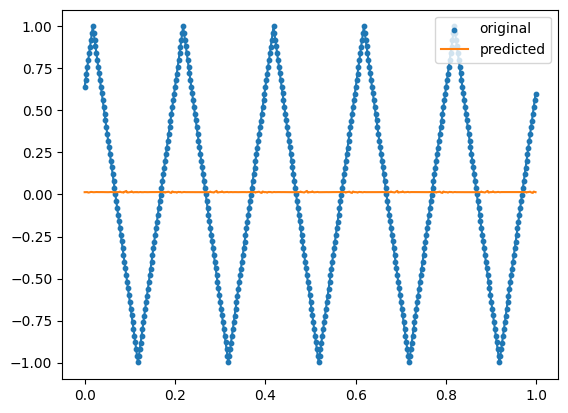

In [678]:
test2(model3,hidden_size,function3,shift,duration,num_time_steps)

In [610]:
model2 = RNN(in_dim, hidden_size, out_dim, sparsity)
train2(model2,n_iter,hidden_size,learning_rate,function1,function3,shift,duration,num_time_steps)

iteration: 3999, loss 0.3342350423336029
iteration: 3999, loss 0.5594966411590576
iteration: 3999, loss 0.5455602407455444
iteration: 3999, loss 0.37944716215133667
iteration: 3999, loss 0.3794559836387634
iteration: 3999, loss 0.3451445400714874
iteration: 3999, loss 0.37429195642471313
iteration: 3999, loss 0.261775940656662
iteration: 3999, loss 0.30199456214904785
iteration: 3999, loss 0.30266937613487244
iteration: 3999, loss 0.25585225224494934
iteration: 3999, loss 0.37508299946784973
iteration: 3999, loss 0.3334428369998932
iteration: 3999, loss 0.3488795757293701
iteration: 3999, loss 0.35277560353279114
iteration: 3999, loss 0.2909364700317383
iteration: 3999, loss 0.317901611328125
iteration: 3999, loss 0.3849061131477356
iteration: 3999, loss 0.3265537917613983
iteration: 3999, loss 0.3134290874004364
iteration: 3999, loss 0.3268270194530487
iteration: 3999, loss 0.29538339376449585
iteration: 3999, loss 0.3401569724082947
iteration: 3999, loss 0.2965831160545349
iteration:

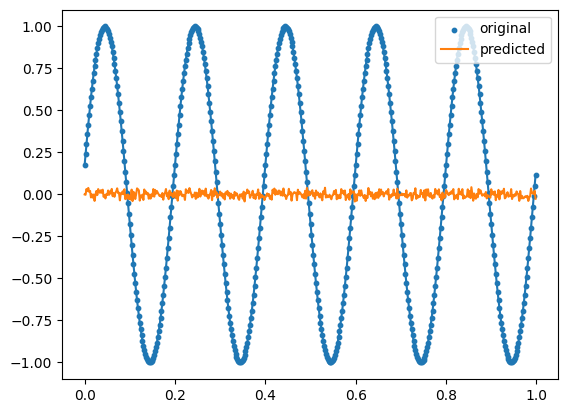

In [611]:
test2(model,hidden_size,function1,shift,duration,num_time_steps)

In [ ]:
n_models = 100
models = [ RNN(in_dim, hidden_size, out_dim, sparsity) for _ in range(n_models)] 

for i, model in enumerate(models):
    if i % 2: 
        function = function1
    else:
        function = function2
        
    train(model,n_iter,in_dim,out_dim,hidden_size,learning_rate,sparsity,function2,shift,sampling_rate,duration,num_time_steps)

In [679]:
import torch
from torch.utils.data import Dataset

class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [ ]:
sequence1 = [1,1,1,0,0,0,1,1,1,0,0,0]
sequence2 = [1,0,1,0,1,0,1,0,1,0,1,0]